In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
with open(f'../../../loss/ResDepth_montecarlo_v2.pkl', 'rb') as f:
        experiment_data = pickle.load(f)

In [10]:
# define input channels for model
all_input_channels = [
    'snowon_vv',
    'snowon_vh',
    'snowoff_vv',
    'snowoff_vh',
    'snowon_cr',
    'snowoff_cr',
    'delta_cr',
    'blue',
    'green',
    'red',
    'nir',
    'swir1',
    'swir2',
    'ndvi',
    'ndsi',
    'ndwi',
    'fcf',
    'snodas_sd',
    'elevation',
    'slope',
    'aspect',
    'northness',
    'eastness',
    'curvature',
    'tri',
    'tpi',
    'latitude',
    'longitude',
    'dowy']

In [11]:
# Convert to DataFrame
trials_df = pd.DataFrame([
    {
        'trial': trial,
        'feature_1': features[0],
        'feature_2': features[1],
        'feature_3': features[2],
        'feature_4': features[3],
        'feature_5': features[4],
        'min_val_loss': min_val_loss
    }
    for trial, (features, min_val_loss) in experiment_data.items()
])

# Sort by minimum validation loss
trials_df = trials_df.sort_values(by='min_val_loss', ascending=True).reset_index(drop=True)

trials_df

,trial,feature_1,feature_2,feature_3,feature_4,feature_5,min_val_loss
0,120,snodas_sd,slope,blue,curvature,snowon_vh,0.00104
1,34,snowoff_vh,snodas_sd,tri,northness,curvature,0.00104
2,124,slope,snowoff_vv,northness,snodas_sd,fcf,0.00108
3,101,tri,snowon_vv,dowy,snodas_sd,ndvi,0.00109
4,40,green,snodas_sd,eastness,snowoff_cr,elevation,0.00112
...,...,...,...,...,...,...,...
212,70,latitude,tpi,dowy,snowoff_vh,curvature,0.00601
213,194,snowoff_vv,dowy,slope,tri,aspect,0.00613
214,35,tri,snowoff_cr,slope,northness,tpi,0.00626
215,187,tpi,swir2,eastness,snowoff_vh,northness,0.00632


In [12]:
## COMPARISON INCLUDING ALL FEATURES

val_channel_performance = {}
all_values = {}
val_w_stdev_list = []
for channel in all_input_channels:
    val_loss_w_channel = []
    val_loss_wo_channel = []
    for trial in experiment_data.keys():
        if channel in experiment_data[trial][0]:
            val_loss_w_channel.append(experiment_data[trial][1])
        else:
            val_loss_wo_channel.append(experiment_data[trial][1])
    val_loss_diff = np.mean(val_loss_w_channel) - np.mean(val_loss_wo_channel)
    val_w_stdev_list.append(np.std(val_loss_w_channel))
    val_channel_performance[channel] = val_loss_diff
    all_values[channel] = [val_loss_w_channel, val_loss_wo_channel]

df = pd.DataFrame({
    'channels': val_channel_performance.keys(),
    'val_loss_diff': val_channel_performance.values(),
    'val_w_stdev':val_w_stdev_list
})

df_summary = df.sort_values('val_loss_diff', ascending=True)

In [6]:
# ## REMOVING SNODAS_SD TRIALS

# val_channel_performance = {}
# all_values = {}
# val_w_stdev_list = []

# for channel in all_input_channels:
#     val_loss_w_channel = []
#     val_loss_wo_channel = []
    
#     for trial in experiment_data.keys():
#         trial_features = experiment_data[trial][0]
#         trial_loss = experiment_data[trial][1]

#         # Skip all trials that include 'snodas_sd' unless the current channel *is* 'snodas_sd'
#         if channel != 'snodas_sd' and 'snodas_sd' in trial_features:
#             continue

#         if channel in trial_features:
#             val_loss_w_channel.append(trial_loss)
#         else:
#             val_loss_wo_channel.append(trial_loss)

#     val_loss_diff = np.mean(val_loss_w_channel) - np.mean(val_loss_wo_channel)
#     val_w_stdev_list.append(np.std(val_loss_w_channel))
#     val_channel_performance[channel] = val_loss_diff
#     all_values[channel] = [val_loss_w_channel, val_loss_wo_channel]


In [13]:
# Find the maximum length of the lists
max_len = max(max(len(lst) for lst in metrics) for metrics in all_values.values())

# Convert dictionary to DataFrame
rows = []
for channel, metrics in all_values.items():
    for i in range(max_len):
        row = [channel]
        for metric in metrics:
            if i < len(metric):
                row.append(metric[i])
            else:
                row.append(np.nan)
        rows.append(row)

df = pd.DataFrame(rows, columns=['channel', 'val_mse_w', 'val_mse_wo'])

In [14]:
from scipy.stats import ttest_ind

results = []

# Perform Welch's t-test for each channel
for channel in df['channel'].unique():
    channel_data = df[df['channel'] == channel]
    channel_obs = channel_data['val_mse_w'].count()
    
    metric_1 = channel_data['val_mse_w'].dropna()
    metric_2 = channel_data['val_mse_wo'].dropna()
    
    # Welch's t-test (assumes unequal variance)
    stat_val, p_val = ttest_ind(metric_1, metric_2, equal_var=False)
    
    results.append([channel, p_val, channel_obs])

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=['channel', 'p_val', 'n'])
pd.set_option('display.float_format', lambda x: '%.5f' % x)
results_df

,channel,p_val,n
0,snowon_vv,0.27025,29
1,snowon_vh,0.13039,38
2,snowoff_vv,0.89060,39
3,snowoff_vh,0.07449,36
4,snowon_cr,0.35123,26
5,snowoff_cr,0.04543,40
6,delta_cr,0.66601,31
7,blue,0.00001,39
8,green,0.02651,42
9,red,0.00009,30


In [15]:
results_df.n.mean()

37.41379310344828

In [16]:
improved_list = []
worse_list = []
for key, value in all_values.items():
    stat_val, p_val = ttest_ind(value[0], value[1], equal_var=False)
    included_median = np.median(value[0])
    excluded_median = np.median(value[1])
    if included_median < excluded_median:
        improved_list.append([key, p_val])
    else:
        worse_list.append([key, p_val])

improved_sorted = sorted(improved_list, key=lambda x: x[1], reverse=False)
worse_sorted = sorted(worse_list, key=lambda x: x[1], reverse=True)

improved_names = [item[0] for item in improved_sorted]
worse_names = [item[0] for item in worse_sorted]
sorted_columns = improved_names + worse_names

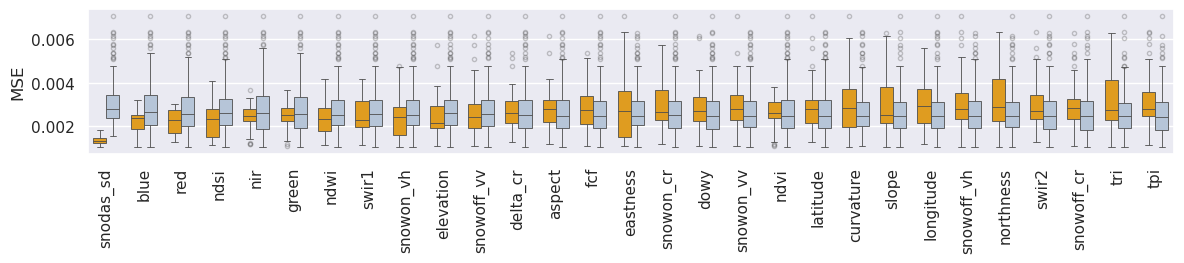

In [17]:
sns.set_theme()

# Melt the DataFrame
df_melted = pd.melt(df, id_vars=['channel'], value_vars=['val_mse_w', 'val_mse_wo'], var_name='metric', value_name='value')

# Custom colors for each metric
palette = {'val_mse_w': 'orange', 'val_mse_wo': 'lightsteelblue'}

# Create subplots
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 2.8))

# Bottom plot: Performance metrics 3 and 4
sns.boxplot(x='channel', y='value', hue='metric', order=sorted_columns, data=df_melted, ax=ax,
           flierprops={"marker": "o", "alpha": 0.3}, fliersize=3, palette=palette, legend=False,
           linewidth=0.6, width=0.7)
#ax.set_title('validation performance with and without channel')
ax.set_ylabel('MSE')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(None, None)

# Adjust layout
plt.tight_layout()


# Save the plot
#plt.savefig('../../figs/monte_carlo_MSE.png', dpi=300, bbox_inches="tight")

In [24]:
feature = 'snodas_sd'

all_values_with_snodas = {}

for channel in all_input_channels:
    if channel == feature:
        continue  # skip snodas_sd as a feature of interest

    val_loss_w_channel = []
    val_loss_wo_channel = []

    for trial, (features, loss) in experiment_data.items():
        if feature not in features:
            continue  # only consider trials that include snodas_sd

        if channel in features:
            val_loss_w_channel.append(loss)
        else:
            val_loss_wo_channel.append(loss)

    all_values_with_snodas[channel] = [val_loss_w_channel, val_loss_wo_channel]

# Find the maximum length of the lists
max_len = max(max(len(lst) for lst in metrics) for metrics in all_values_with_snodas.values())

# Convert dictionary to DataFrame
rows = []
for channel, metrics in all_values_with_snodas.items():
    for i in range(max_len):
        row = [channel]
        for metric in metrics:
            if i < len(metric):
                row.append(metric[i])
            else:
                row.append(np.nan)
        rows.append(row)

df_with_snodas = pd.DataFrame(rows, columns=['channel', 'val_mse_w', 'val_mse_wo'])

results_with_snodas = []

# Perform Welch's t-test for each channel
for channel in df_with_snodas['channel'].unique():
    channel_data = df_with_snodas[df_with_snodas['channel'] == channel]
    channel_obs = channel_data['val_mse_w'].count()
    
    metric_1 = channel_data['val_mse_w'].dropna()
    metric_2 = channel_data['val_mse_wo'].dropna()
    
    # Welch's t-test (assumes unequal variance)
    stat_val, p_val = ttest_ind(metric_1, metric_2, equal_var=False)
    
    results_with_snodas.append([channel, p_val, channel_obs])

# Convert to DataFrame
results_with_snodas_df = pd.DataFrame(results_with_snodas, columns=['channel', 'p_val', 'n'])
pd.set_option('display.float_format', lambda x: '%.5f' % x)
results_with_snodas_df

,channel,p_val,n
0,snowon_vv,0.11635,4
1,snowon_vh,0.96899,9
2,snowoff_vv,0.41899,9
3,snowoff_vh,0.87815,6
4,snowon_cr,0.85681,4
5,snowoff_cr,0.70669,4
6,delta_cr,0.50283,3
7,blue,0.83989,6
8,green,0.72643,7
9,red,0.16012,7


In [25]:
improved_list_with_snodas = []
worse_list_with_snodas = []
for key, value in all_values_with_snodas.items():
    stat_val, p_val = ttest_ind(value[0], value[1], equal_var=False)
    included_median = np.median(value[0])
    excluded_median = np.median(value[1])
    if included_median < excluded_median:
        improved_list_with_snodas.append([key, p_val])
    else:
        worse_list_with_snodas.append([key, p_val])

improved_with_snodas_sorted = sorted(improved_list_with_snodas, key=lambda x: x[1], reverse=False)
worse_with_snodas_sorted = sorted(worse_list_with_snodas, key=lambda x: x[1], reverse=True)

improved_names_with_snodas = [item[0] for item in improved_with_snodas_sorted]
worse_names_with_snodas = [item[0] for item in worse_with_snodas_sorted]
sorted_columns_with_snodas = improved_names_with_snodas + worse_names_with_snodas

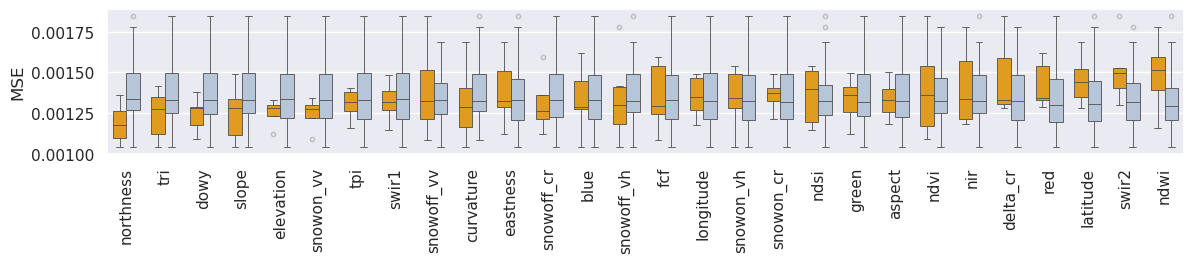

In [26]:
sns.set_theme()

# Melt the DataFrame
df_with_snodas_melted = pd.melt(df_with_snodas, id_vars=['channel'], value_vars=['val_mse_w', 'val_mse_wo'], var_name='metric', value_name='value')

# Custom colors for each metric
palette = {'val_mse_w': 'orange', 'val_mse_wo': 'lightsteelblue'}

# Create subplots
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 2.8))

# Bottom plot: Performance metrics 3 and 4
sns.boxplot(x='channel', y='value', hue='metric', order=sorted_columns_with_snodas, data=df_with_snodas_melted, ax=ax,
           flierprops={"marker": "o", "alpha": 0.3}, fliersize=3, palette=palette, legend=False,
           linewidth=0.6, width=0.7)
#ax.set_title('validation performance with and without channel')
ax.set_ylabel('MSE')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(None, None)

# Adjust layout
plt.tight_layout()


# Save the plot
#plt.savefig('../../figs/monte_carlo_MSE.png', dpi=300, bbox_inches="tight")

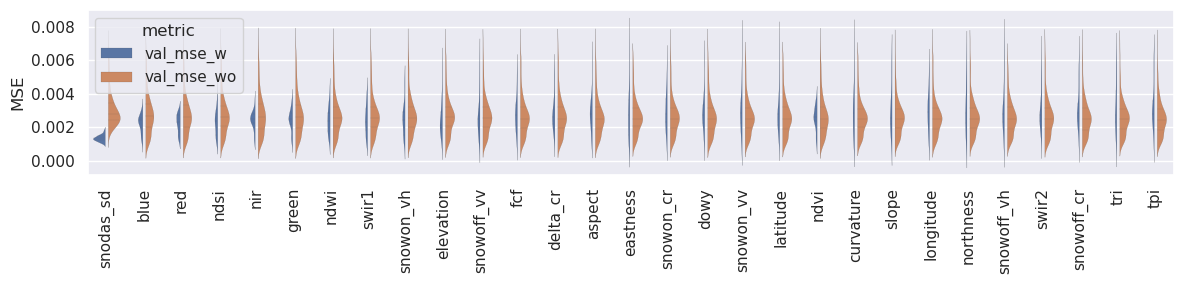

In [113]:
# Melt the DataFrame
df_melted = pd.melt(df, id_vars=['channel'], value_vars=['val_mse_w', 'val_mse_wo'], var_name='metric', value_name='value')

sns.set_theme()

# Create subplots
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))

# Violin plot with split
sns.violinplot(x='channel', y='value', hue='metric', inner='quart', linewidth=0.1, gap=0.2, data=df_melted, order=sorted_columns, split=True, ax=ax)
#ax.set_title('Validation Performance with and without Channel')
ax.set_ylabel('MSE')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(None, None)

# Adjust layout
plt.tight_layout()

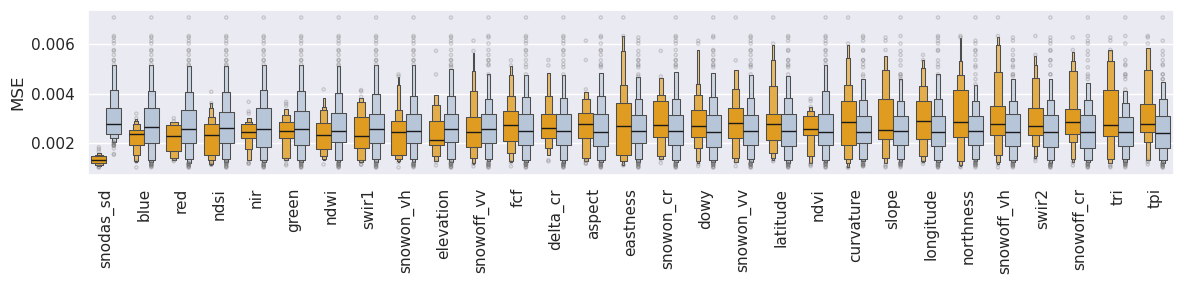

In [114]:
# Create subplots
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))

# Custom colors for each metric
palette = {'val_mse_w': 'orange', 'val_mse_wo': 'lightsteelblue'}

# Swarm plot
sns.boxenplot(x='channel', y='value', hue='metric', data=df_melted, order=sorted_columns,
              ax=ax, k_depth='proportion', outlier_prop=0.2, flier_kws={"marker": "o", 's':5, "alpha": 0.3},
              line_kws=dict(linewidth=1, color="k"), legend=False, palette=palette)
ax.set_ylabel('MSE')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(None, None)

# Adjust layout
plt.tight_layout()
plt.show()

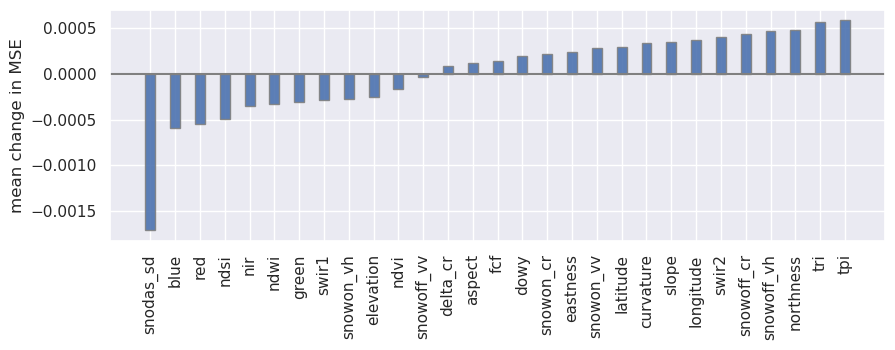

In [27]:
# Set the position of the bars on the x-axis
bar_width = 0.4
r1 = np.arange(len(df_summary['channels']))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(r1, df_summary['val_loss_diff'], width=bar_width, edgecolor='grey', alpha=0.9)
# Add labels
ax.set_xlabel('')
ax.set_xticks([r for r in range(len(df_summary['channels']))])
ax.set_xticklabels(df_summary['channels'], rotation=90)
ax.set_ylabel('mean change in MSE')
ax.axhline(0, c='grey')
#ax.set_title('mean change in validation MSE when channels are included')
#plt.savefig('../../figs/monte_carlo_MSE_change.png', dpi=300)

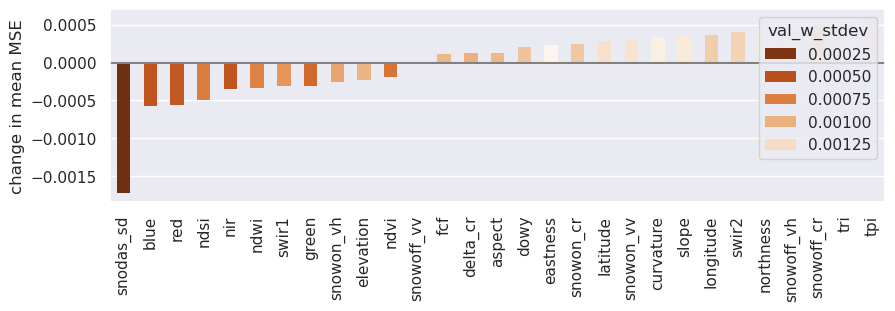

In [116]:
sns.set_theme()
# Create the plot
fig, ax = plt.subplots(figsize=(10, 2.5))
sns.barplot(x='channels', y='val_loss_diff', hue='val_w_stdev', palette='Oranges_r', data=df_summary, linewidth=0, legend=True, width=0.5)

# Add labels
ax.set_xlabel('')
ax.set_xticks([r for r in range(len(df_summary['channels']))])
ax.set_xticklabels(df_summary['channels'], rotation=90)
ax.set_ylabel('change in mean MSE')
ax.axhline(0, c='grey')
# ax.set_title('mean change in validation MSE when channels are included')

# Save the plot
#plt.savefig('../../figs/monte_carlo_MSE_change.png', dpi=300, bbox_inches="tight")

ValueError: The following variable cannot be assigned with wide-form data: `hue`

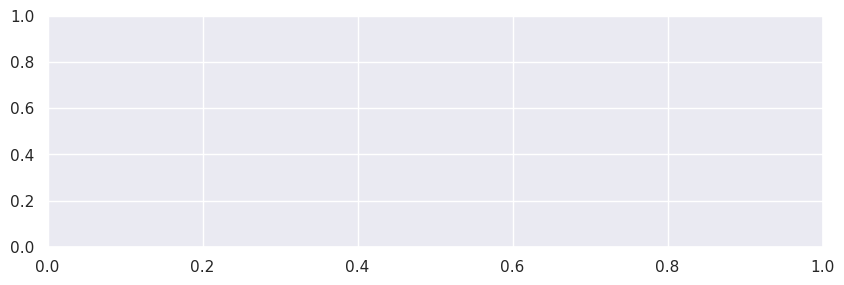

In [16]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(df_summary['val_loss_diff'], hue=df_summary['val_w_stdev'])
# Add labels
ax.set_xlabel('')
ax.set_xticks([r for r in range(len(df_summary['channels']))])
ax.set_xticklabels(df_summary['channels'], rotation=90)
ax.set_ylabel('mean change in MSE')
ax.axhline(0, c='grey')
#ax.set_title('mean change in validation MSE when channels are included')
#plt.savefig('../../figs/monte_carlo_MSE_change.png', dpi=300)

In [ ]:
experiment_data